# **Insurance Dataset**
___

In [5]:
# Se importan las librerías necesarias
library(tidyverse)
#library(ggridges)
#library(ggpubr)

# Directorio de trabajo y nombre de archivo
data_folder <- "dataset"
file_name <- "insurance.csv"

# Se importa el dataset
df_seguros <- read.csv(file.path(data_folder, file_name), dec=".")

# Cambia tamaño del plot
options(repr.plot.width=12, repr.plot.height=10)

In [6]:
# Agrego datos sobre obesidad
df_seguros <- mutate(df_seguros,
                     obesidad = bmi >= 30,
                     rango_etario = case_when((18 <= age & age < 30) ~ '18 a 29', 
                               (30 <= age & age < 40) ~ '30 a 39', 
                               (40 <= age & age < 50) ~ '40 a 49', 
                               (50 <= age & age < 60) ~ '50 a 59', 
                               (60 <= age) ~ '60 <='),
                     salud = case_when((obesidad == TRUE & smoker == 'yes') ~ 'FO', 
                                              (obesidad == TRUE & smoker == 'no') ~ 'O', 
                                              (obesidad == FALSE & smoker == 'yes') ~ 'F', 
                                              (obesidad == FALSE & smoker == 'no') ~ 'S'))

# Summarise de cantidad de habitantes por zona
df_seguros_2 <- group_by(df_seguros, region)
metricas_df2 <- summarise(df_seguros_2, habitantes=n())

# Agrupo para hacer tabla de metricas por region, obesidad y smoker
df_seguros_3 <- group_by(df_seguros, salud, region)
metricas_df3 <- summarise(df_seguros_3,
          mediana_ch=median(charges),
          media_ch=mean(charges),
          cantidad=n(),
          edad_med=median(age))

metricas_merge <- merge(metricas_df2, metricas_df3, by='region')
metricas_merge <- mutate(metricas_merge,
                         poblacion_pje=round(cantidad/habitantes*100, 2),
                         ganancia_grupo=(10000*0.70*0.25)*mediana_ch,
                         ganancia_real=(10000*0.70*0.25*poblacion_pje/100)*mediana_ch)

# Modificar tabla de proporcion 
### TABLA ####

# Calculo ganancias promedio por region
metricas_merge2 <- group_by(metricas_merge, region)
metricas_merge2 <- summarise(metricas_merge2,
                             gananciaG_prom=mean(ganancia_grupo),
                             gananciaG_med=median(ganancia_grupo),
                             gananciaR_total=sum(ganancia_real))

`summarise()` has grouped output by 'salud'. You can override using the `.groups` argument.


### **Resumen**

Una empresa proveedora de seguros médicos está planeando una campaña publicitaria en la vía pública y desea colocar carteles. Para ello divide el territorio de estudio en 4 zonas con el objetivo de elegir la zona donde pueda maximizar sus ganancias sobre futuros clientes que contraten el seguro. Estudiaremos a continuación el dataset provisto con el fin de contribuir en la toma de decisiones de la empresa.

### **Qué clientes pagan costos de seguro más elevado**
Considerando que los factores de riesgo en el dataset son la obesidad (definida como el Índice de Masa Corporal (BMI, en inglés) mayor a 30) y el consumo de nicotina, se compararon los gastos de seguro médico de personas fumadoras y no fumadoras, separadas por su condición de obesidad.
En el siguiente gráfico se observa que los fumadores tienen más gastos de seguro médico que los no fumadores y, además, si los fumadores son obesos, pagan aún más.

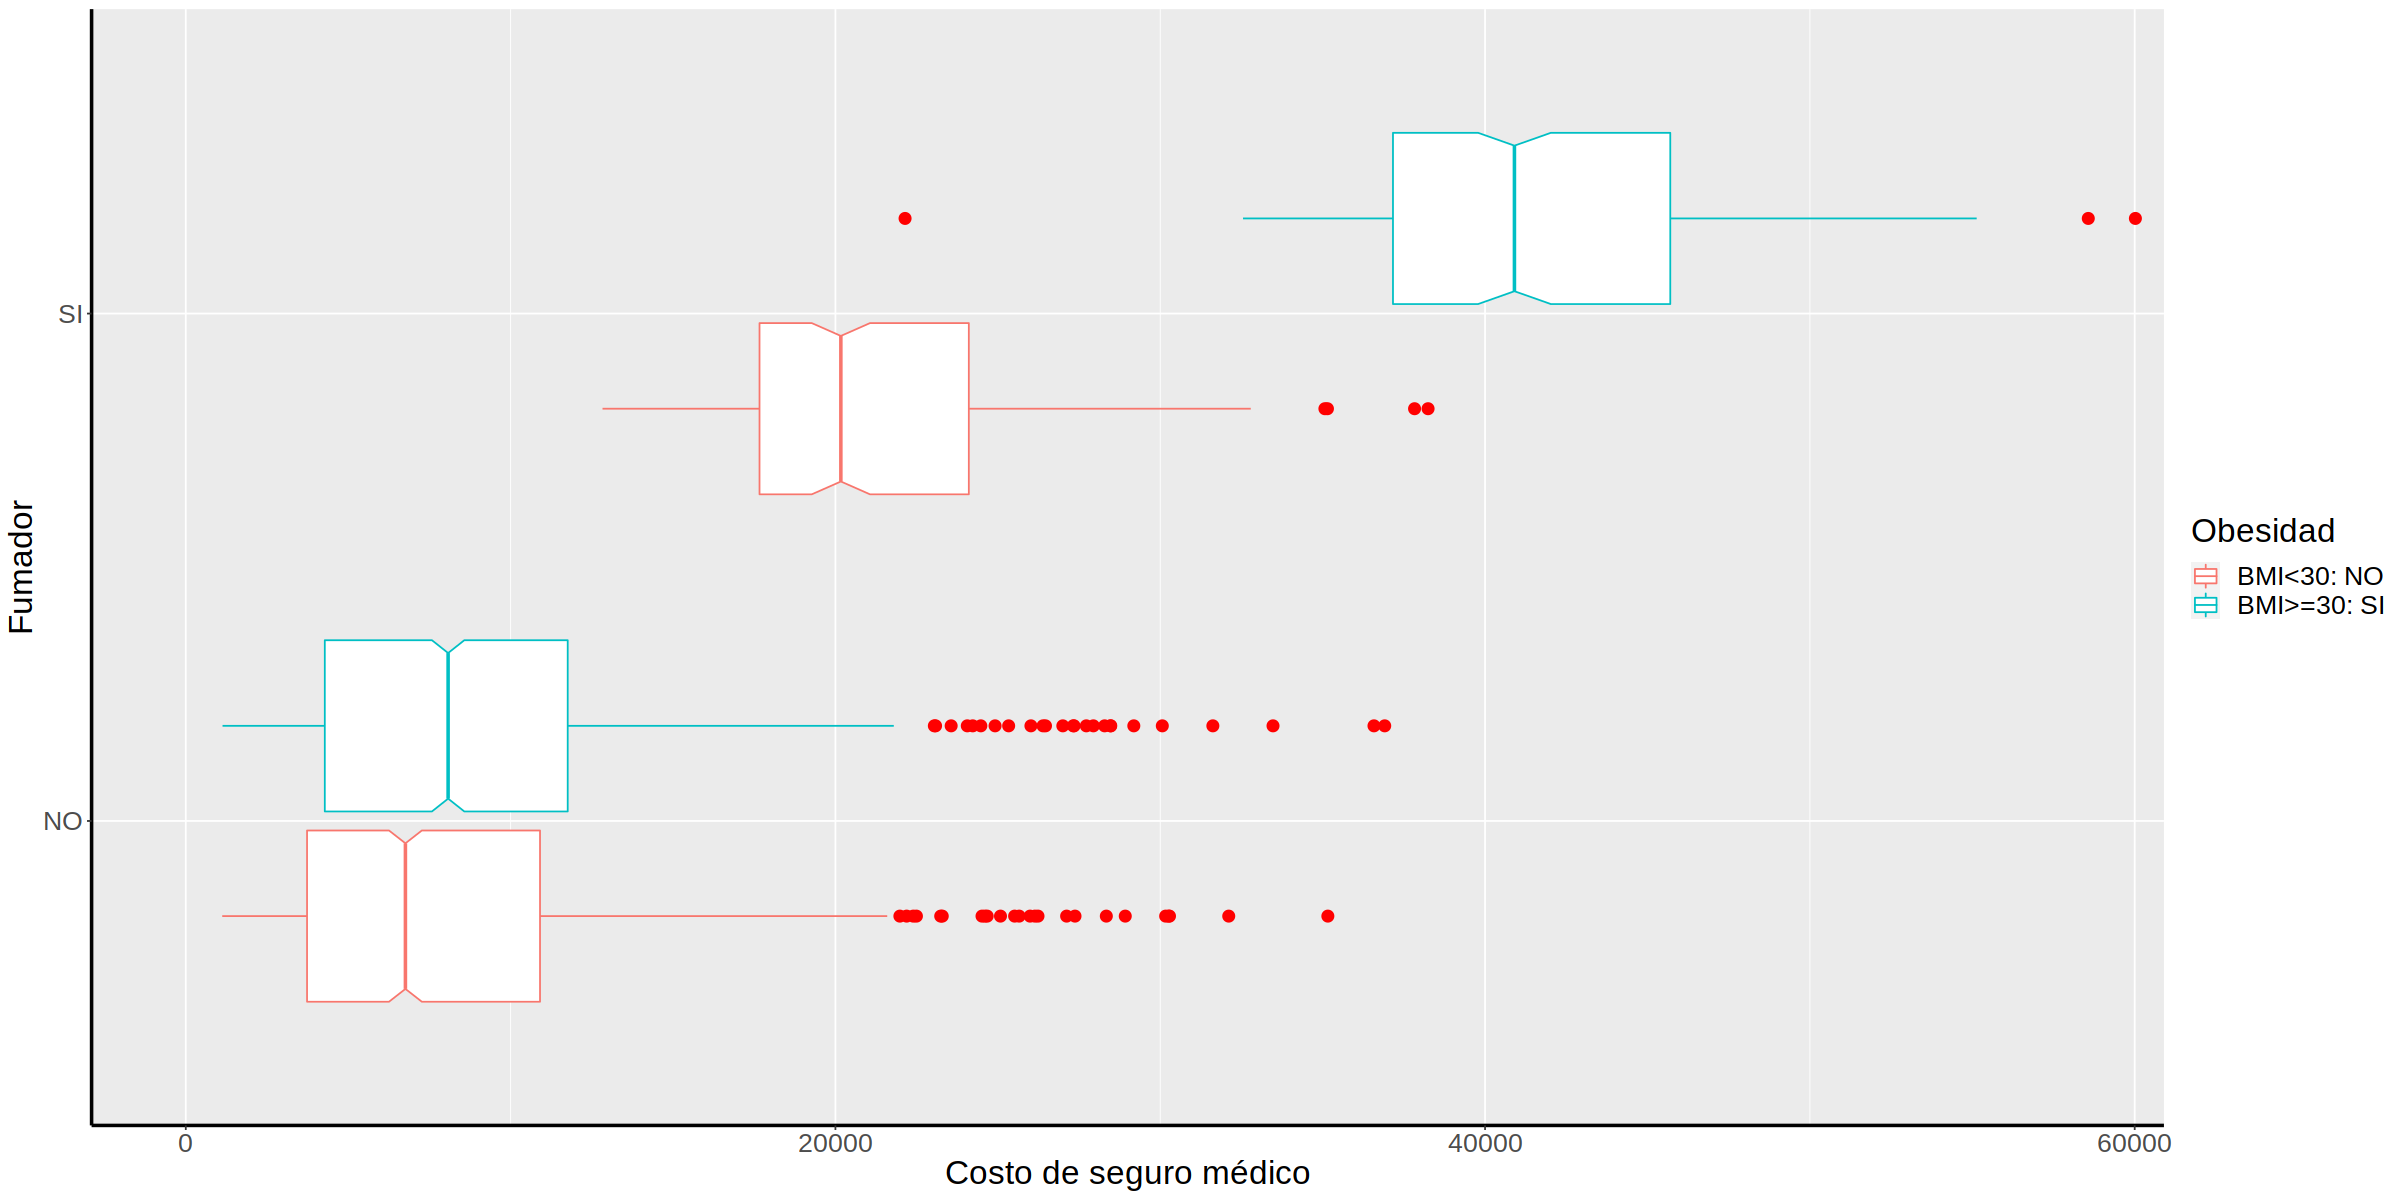

In [7]:
# Cambia tamaño del plot
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data=df_seguros, aes(y=factor(smoker), x=charges, color=obesidad)) + 
    geom_boxplot(outlier.colour = "red", outlier.fill="red", outlier.size=3, notch=TRUE, notchwidth = 0.85) +
    labs(x = 'Costo de seguro médico', color = 'Obesidad') +
    scale_color_discrete(labels=c('BMI<30: NO','BMI>=30: SI')) +
    scale_y_discrete('Fumador',labels=c('NO','SI')) +
    coord_cartesian(xlim=c(0, 58000)) +
    theme(axis.line = element_line(colour = "black", size = 1), text = element_text(size = 20))

#### ***Figura 1.*** Costo de seguro médico para personas sanas, con obesidad o tabaquismo y con tabaquismo y obesidad. [6]<a id="6"></a>

También se analizó si el tener más hijos, tanto para hombres y como mujeres, modifica el gasto en seguro médico. Inicialmente, se presuponía que los hombres no contaran con diferencias en los gastos médicos, sin importar la cantidad de hijos, y que las mujeres pagarían un costo mayor. Estos preconceptos se deben a contextos sociales y económicos, pero también a condiciones asociadas al embarazo y la gestación, por ejemplo, que el proceso de gestación genera cambios en el cuerpo y puede incuso generar problemas de salud. A continuación, se puede ver en el gráfico que la cantidad de hijos no es un factor relevante en los gastos de seguro médico, lo que contradice la suposición. Incluso mostrando casos donde a mayor cantidad de hijos menor gastos.

In [8]:
# separo mujeres de hombres
genero <- group_by(df_seguros, sex, children) %>%
  mutate(rango_hijes = case_when(
    (children==0) ~ 'Sin hijes',
    (children > 0 & children <= 2 ) ~ 'Hasta 2 hijes',
    (children > 2) ~ 'Más de 2 hijes'
  ))

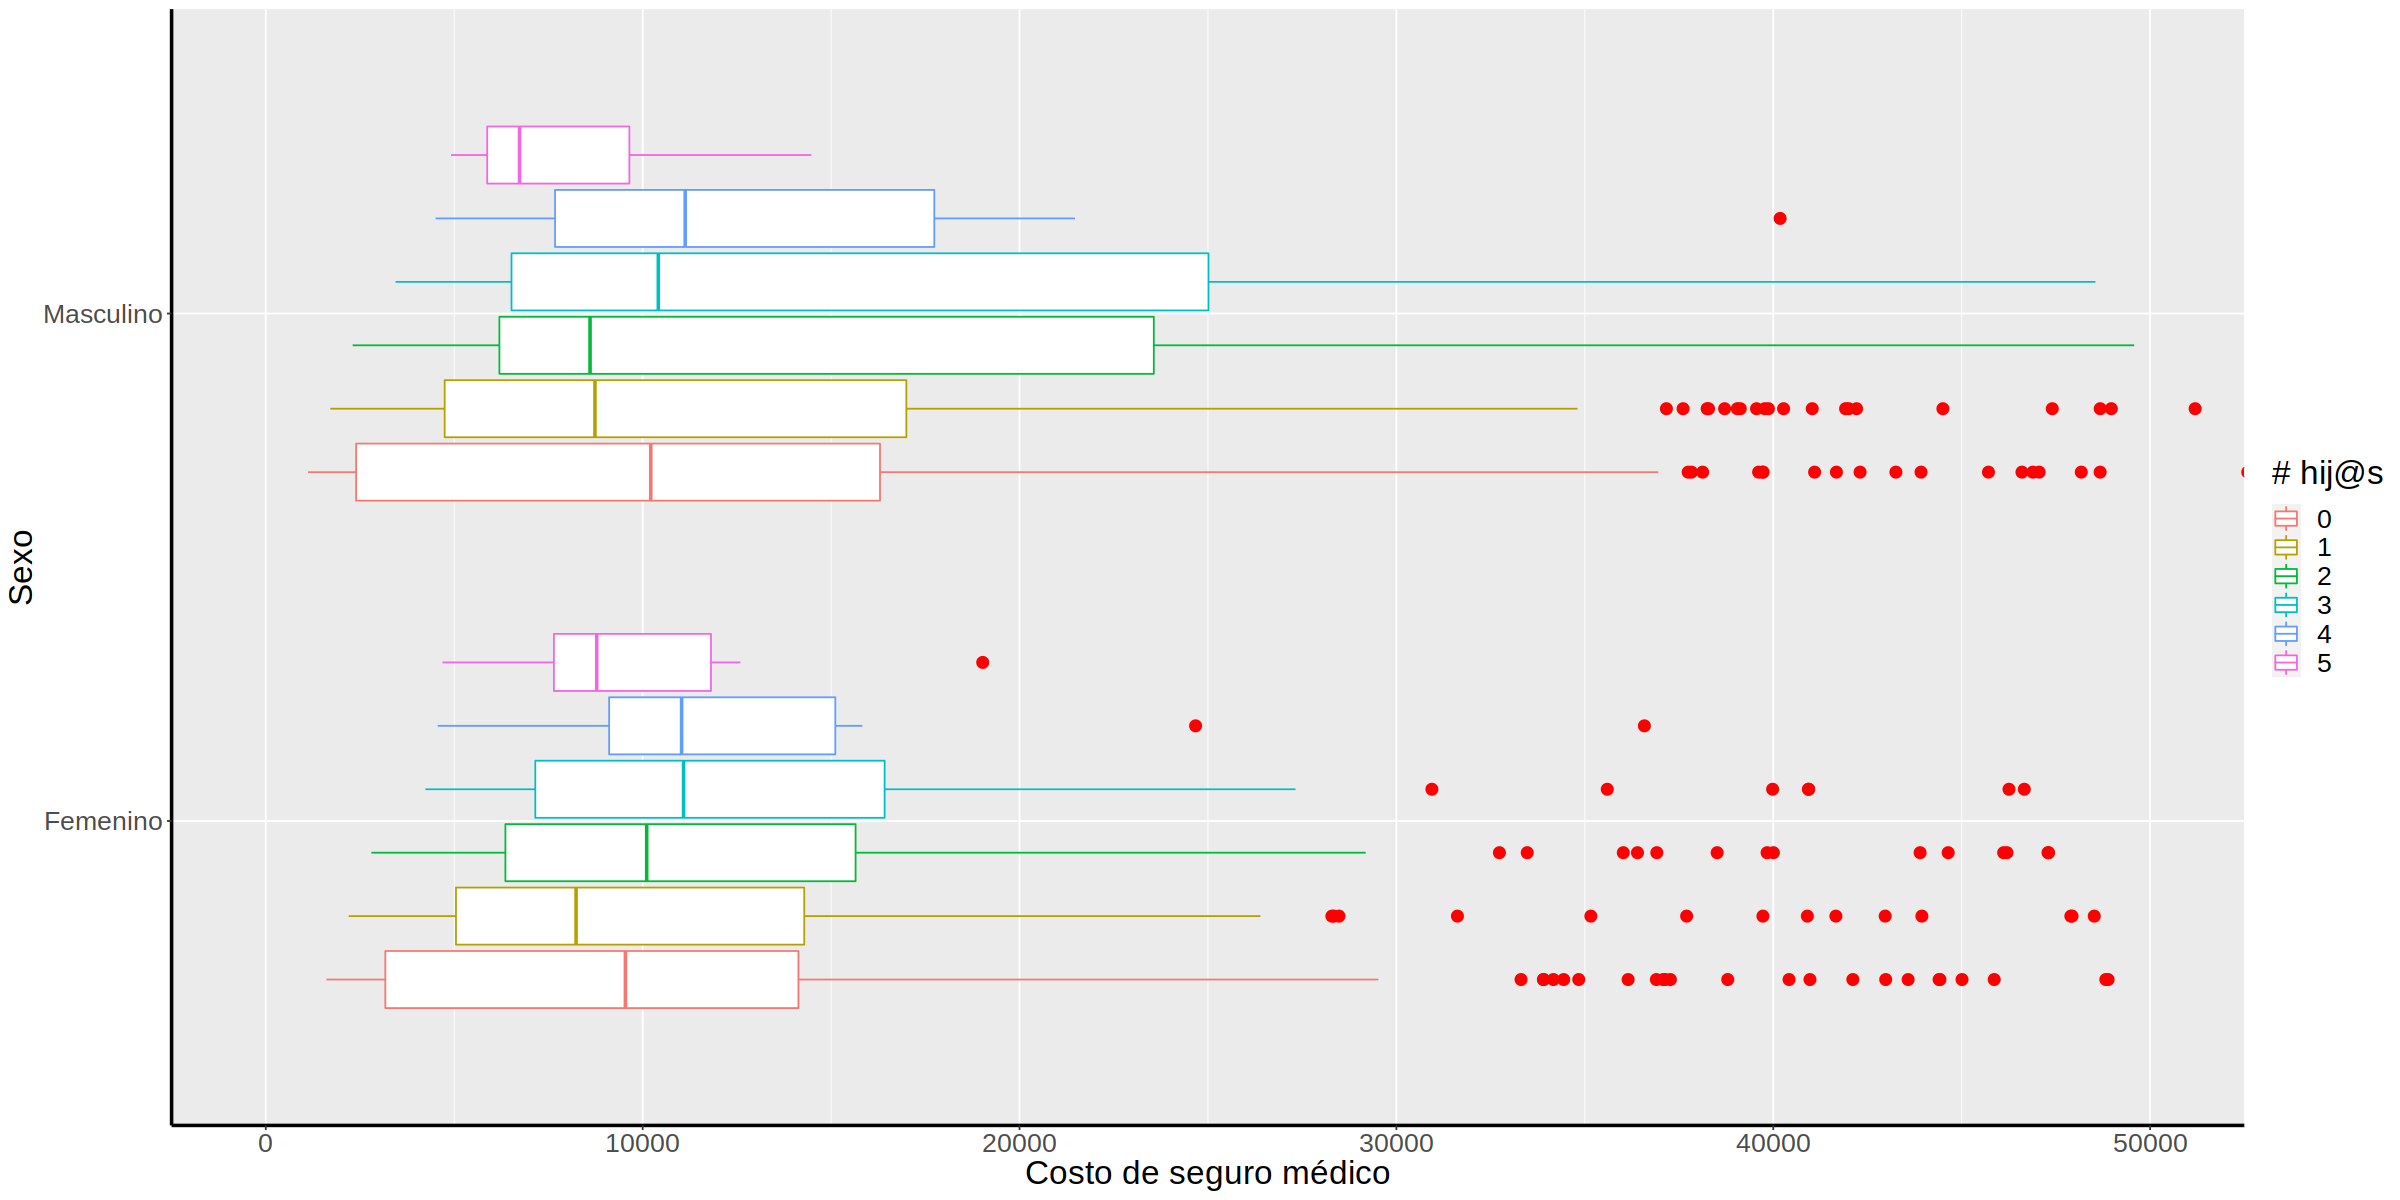

In [9]:
# Cambia tamaño del plot
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data=df_seguros, aes(y=sex, x=charges, color=factor(children))) + 
    geom_boxplot(outlier.colour = "red", outlier.fill="red", outlier.size=3) +
    labs(x = 'Costo de seguro médico', color = '# hij@s') +
    coord_cartesian(xlim=c(0, 50000)) +
    scale_y_discrete('Sexo',labels=c('Femenino','Masculino')) +
    theme(axis.line = element_line(colour = "black", size = 1), text = element_text(size = 20))

#### ***Figura 2.*** Costo de seguro médico para hombres y mujeres, según la cantidad de hij@s.

### **Buscando la zona adecuada**

En la Fig. 1 [[6]](#6) se mostró que los fumadores y, especialmente los fumadores obesos, son aquellos que pagan mayores sumas por su seguro médico. Sin embargo, mayores ingresos de la empresa no significa mayores ganancias, ya que quedaría por analizar los gastos realizados por los clientes, lo que significa un costo para la empresa. Entonces, es posible que este grupo, que genera mayores ingresos, también sea el grupo que más utilice el servicio, generando mayores gastos en la empresa. Para hacer un análisis más realista, sería necesario tener en cuenta más variables, como la expectativa de vida de los diferentes grupos y los gastos que acarrean. Al no contar con estas variables en el dataset, el análisis se enfocará en maximizar los ingresos de la empresa y no las ganancias.
Se decidió seleccionar la zona que presentaba la mayor proporción de fumadores, y en caso de tener zonas con proporciones similares, enfocarse en la que además tuviera mayores índices de obesidad, ya que este grupo es el que paga mayores sumas por su seguro médico.

In [10]:
df_fumyob <- mutate(df_seguros, obesidad= bmi>=30)
# Se agrupan los datos por regiones y fumadores simultaneamente
fumyob_x_region <- group_by(df_fumyob, region, smoker, obesidad)
# Al dataset anterior se le agrega una variable para contabilizar los fumadores en cada region
fumyob_grupo <- summarise(fumyob_x_region, fumadores=sum(smoker=="yes"), no_fumadores=sum(smoker=="no"))
porc_fumyob <- group_by(fumyob_grupo, region) %>% summarise(smoker, obesidad,
    porcentaje = (fumadores/sum(fumadores+no_fumadores))*100 + (no_fumadores/sum(fumadores+no_fumadores))*100)

# Costos de seguro
cargos_fumyob <- group_by(df_fumyob, region, smoker, obesidad) %>% mutate(ganancias=sum(charges)) %>%
    summarise(ganancia=unique(ganancias))
cargos <- group_by(df_fumyob, region) %>% mutate(gcias_region=sum(charges)) %>% summarise(gcias_region=unique(gcias_region))
tabla <- merge(porc_fumyob, merge(cargos_fumyob, cargos)) %>% mutate(porc_gcias=ganancia/gcias_region*100)

`summarise()` has grouped output by 'region', 'smoker'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'region'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'region', 'smoker'. You can override using the `.groups` argument.


In [11]:
tabla

region,smoker,obesidad,porcentaje,ganancia,gcias_region,porc_gcias
<chr>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>
northeast,no,FALSE,44.135802,1183610.2,4343669,27.24909
northeast,no,TRUE,35.185185,1171931.4,4343669,26.98022
northeast,yes,FALSE,11.728395,791146.5,4343669,18.21379
northeast,yes,TRUE,8.950617,1196980.4,4343669,27.55690
northwest,no,FALSE,43.692308,1142479.5,4035712,28.30924
northwest,no,TRUE,38.461538,1142096.4,4035712,28.29975
northwest,yes,FALSE,10.769231,775354.7,4035712,19.21234
northwest,yes,TRUE,7.076923,975781.5,4035712,24.17867
southeast,no,FALSE,24.175824,687036.0,5363690,12.80902


#### ***Tabla 1.*** Distribución de población por regiones, según sus parámetros de salud.

A partir de estos resultados, se decidió concentrar los esfuerzos en la zona Southeast, ya que tiene una mayor proporción de personas con factores de riesgo que pagarán más seguro médico.

### **Potenciales beneficios para la aseguradora**

Si se colocan 500 carteles en la zona elegida, se estima que se alcanzará al 70% de la población, y de las personas que lo vieron, el 25% contratará el segudo, por lo que en total el 17,5% de la población contratará el seguro. Para un área de 10.000 habitantes, son 1750 nuevos clientes.

Para estimar los beneficios mínimos y máximos, se consideró que el ingreso mínimo ocurre cuando todos los nuevos clientes son no fumadores sin obesidad, y el ingreso máximo ocurre si todos los nuevos clientes son fumadores obesos. El ingreso individual que se consideró es el de la mediana de cada grupo.
Para que estas estimaciones tengan valor se considera que la muestra recibida es representativa de la población.

In [12]:
metricas_merge

region,habitantes,salud,mediana_ch,media_ch,cantidad,edad_med,poblacion_pje,ganancia_grupo,ganancia_real
<chr>,<int>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
northeast,324,F,20223.093,20819.646,38,38.0,11.73,35390413,4151295
northeast,324,FO,40904.200,41275.186,29,40.0,8.95,71582349,6406620
northeast,324,O,9870.993,10280.100,114,46.0,35.19,17274237,6078804
northeast,324,S,7077.189,8276.995,143,36.0,44.14,12385081,5466775
northwest,325,F,21472.479,22152.992,35,42.0,10.77,37576838,4047025
northwest,325,FO,42760.502,42425.281,23,44.0,7.08,74830879,5298026
northwest,325,O,7749.156,9136.771,125,41.0,38.46,13561024,5215570
northwest,325,S,6675.559,8045.630,142,37.0,43.69,11682228,5103965
southeast,364,F,19539.243,21819.506,33,40.0,9.07,34193675,3101366


#### ***Tabla 2.*** Donde, personas S: sanas, O: obesas, F: fumadores y FO: fumadoras y obesas.

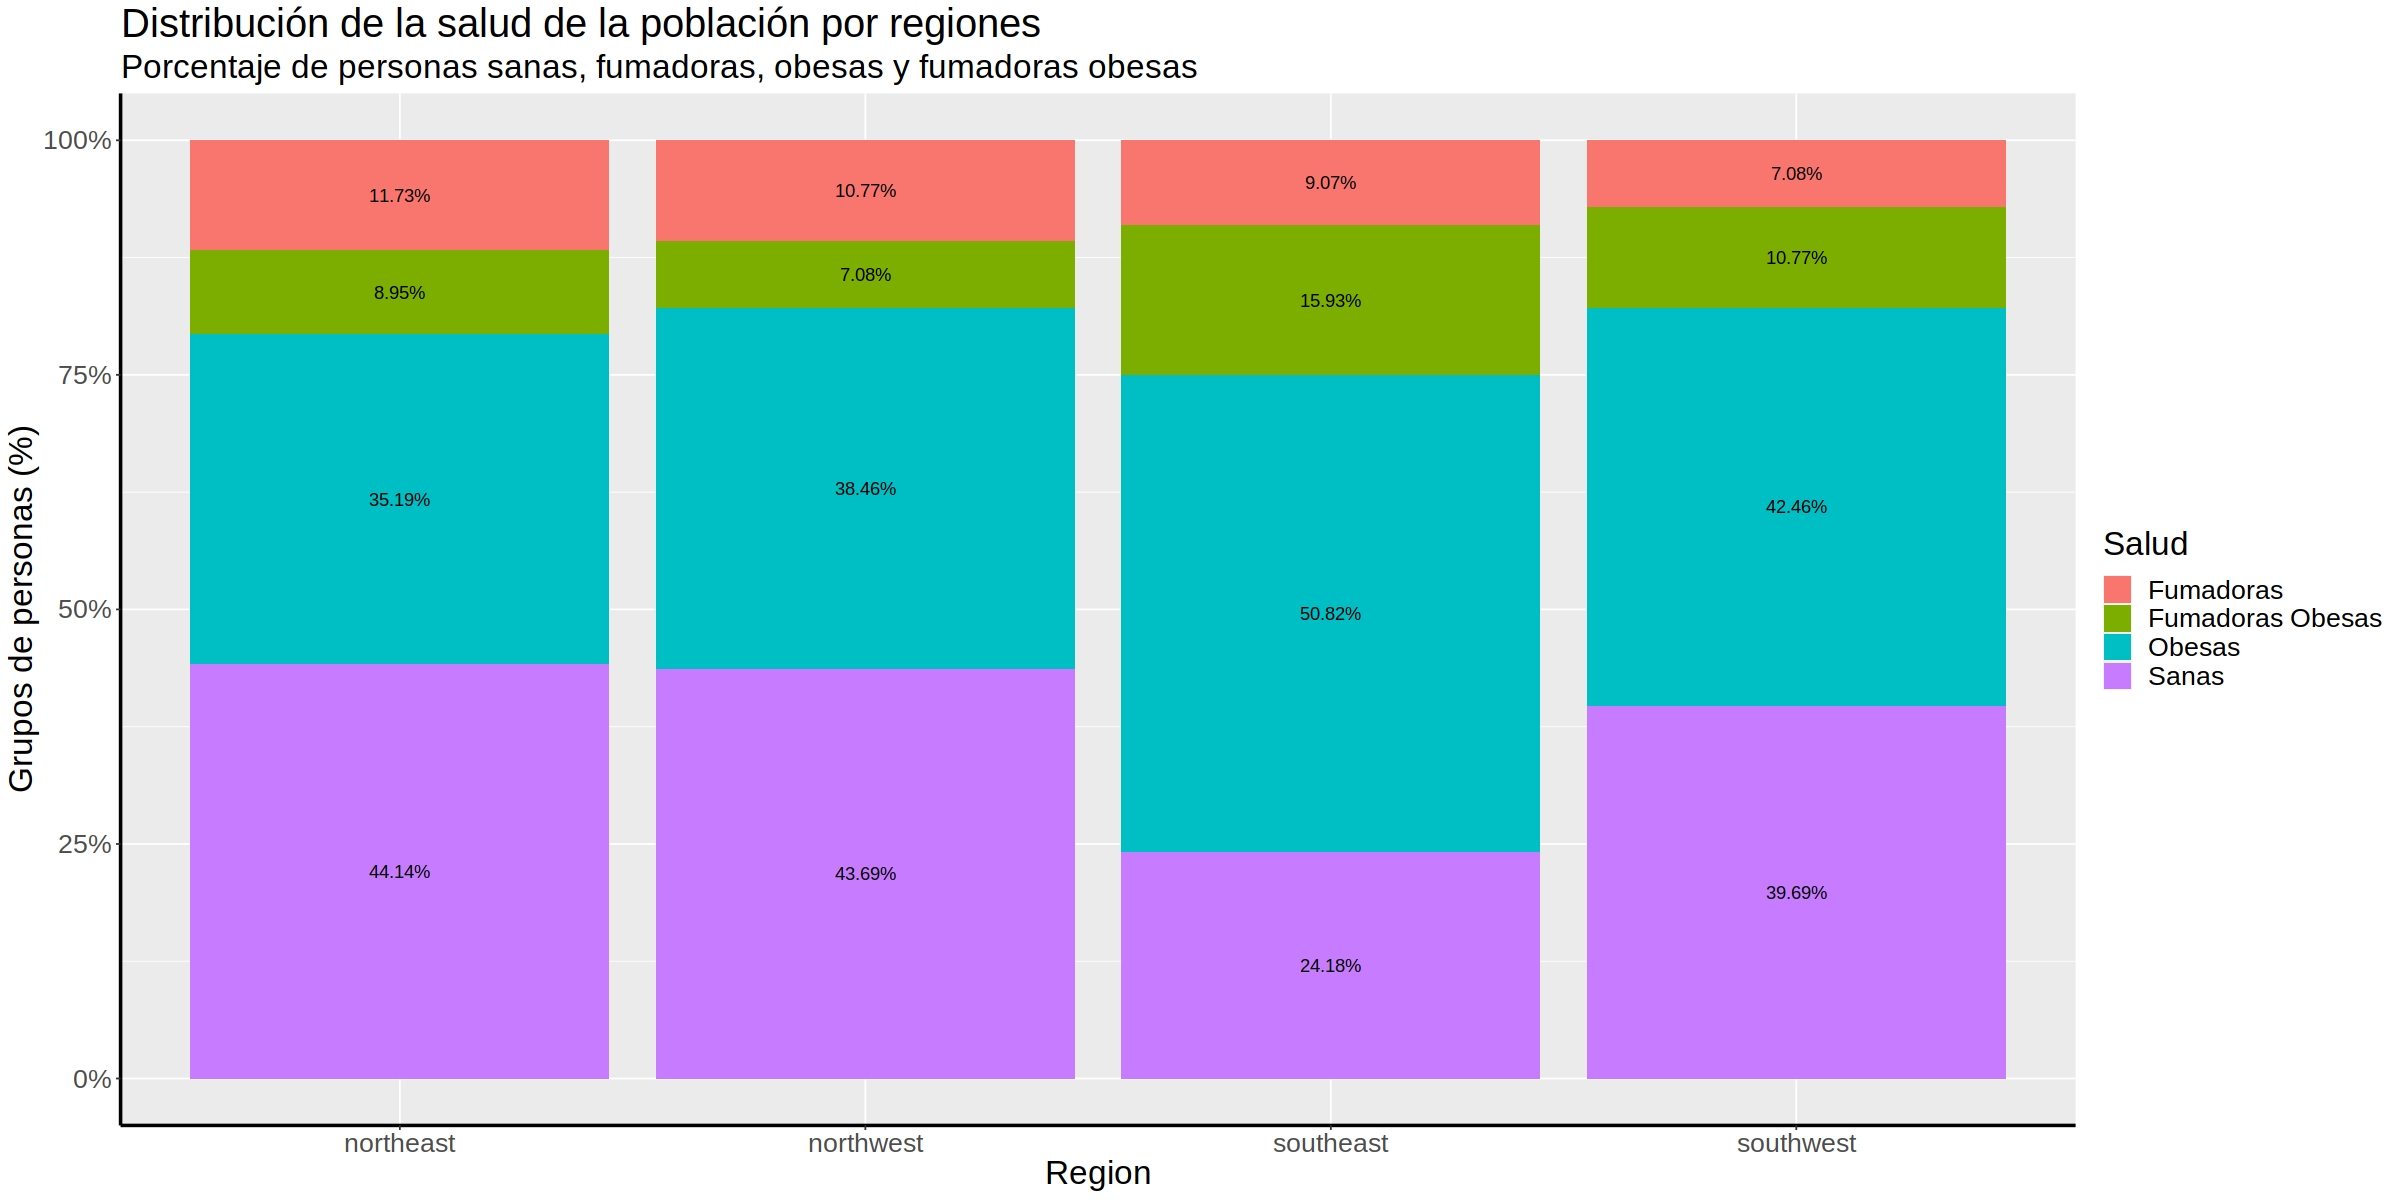

In [13]:
# Grafico de porcentaje de poblacion por grupo
ggplot(metricas_merge, aes(fill=salud, y=poblacion_pje, x=region)) + 
    geom_bar(position="fill", stat="identity") +
    labs(
    title = "Distribución de la salud de la población por regiones",
    subtitle = "Porcentaje de personas sanas, fumadoras, obesas y fumadoras obesas",
    fill = "Salud"
    ) +
    xlab("Region") +
    ylab("Grupos de personas (%)") +
    scale_fill_discrete(labels=c('Fumadoras', 'Fumadoras Obesas', 'Obesas', 'Sanas')) +
    scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
    geom_text(aes(label = paste0(poblacion_pje,"%")),
            colour = "black",
            position = position_fill(vjust = 0.5)) +
    theme(axis.line = element_line(colour = "black", size = 1), text = element_text(size = 20))

#### ***Figura 2.*** Costo de seguro médico para hombres y mujeres, según la cantidad de hij@s.

Con estos resultados, se decidió concentrar los esfuerzos en la zona Southeast, ya que tiene una mayor proporción de personas con factores de riesgo que pagarán más seguro médico.

## Calculando los potenciales beneficios

Si se colocan 500 carteles en la zona elegida, se estima que se alcanzará al 70% de la población, y de las personas que lo vieron, el 25% contratará el segudo, por lo que en total el 17,5% de la población contratará el seguro. Para un área de 10.000 habitantes, son 1750 potenciales nuevos clientes.

Para cada grupo con distintos factores de riesgo se calculó la mediana por edad y se hizo un gráfico de puntos. De este modo se hizo una regresión lineal para poder estimar el ingreso por edad.

In [14]:
df_seguros <- mutate(df_seguros,
                     obesidad = bmi >= 30,
                     rango_etario = case_when((18 <= age & age < 30) ~ '18 a 29', 
                               (30 <= age & age < 40) ~ '30 a 39', 
                               (40 <= age & age < 50) ~ '40 a 49', 
                               (50 <= age & age < 60) ~ '50 a 59', 
                               (60 <= age) ~ '60 <='),
                     salud = case_when((obesidad == TRUE & smoker == 'yes') ~ 'FO', 
                                              (obesidad == TRUE & smoker == 'no') ~ 'O', 
                                              (obesidad == FALSE & smoker == 'yes') ~ 'F', 
                                              (obesidad == FALSE & smoker == 'no') ~ 'SANO'))
df_seguros_3 <- group_by(df_seguros, salud, age)
metricas_df3 <- summarise(df_seguros_3, mediana_ch=median(charges), media_ch=mean(charges), cantidad=n())

`summarise()` has grouped output by 'salud'. You can override using the `.groups` argument.


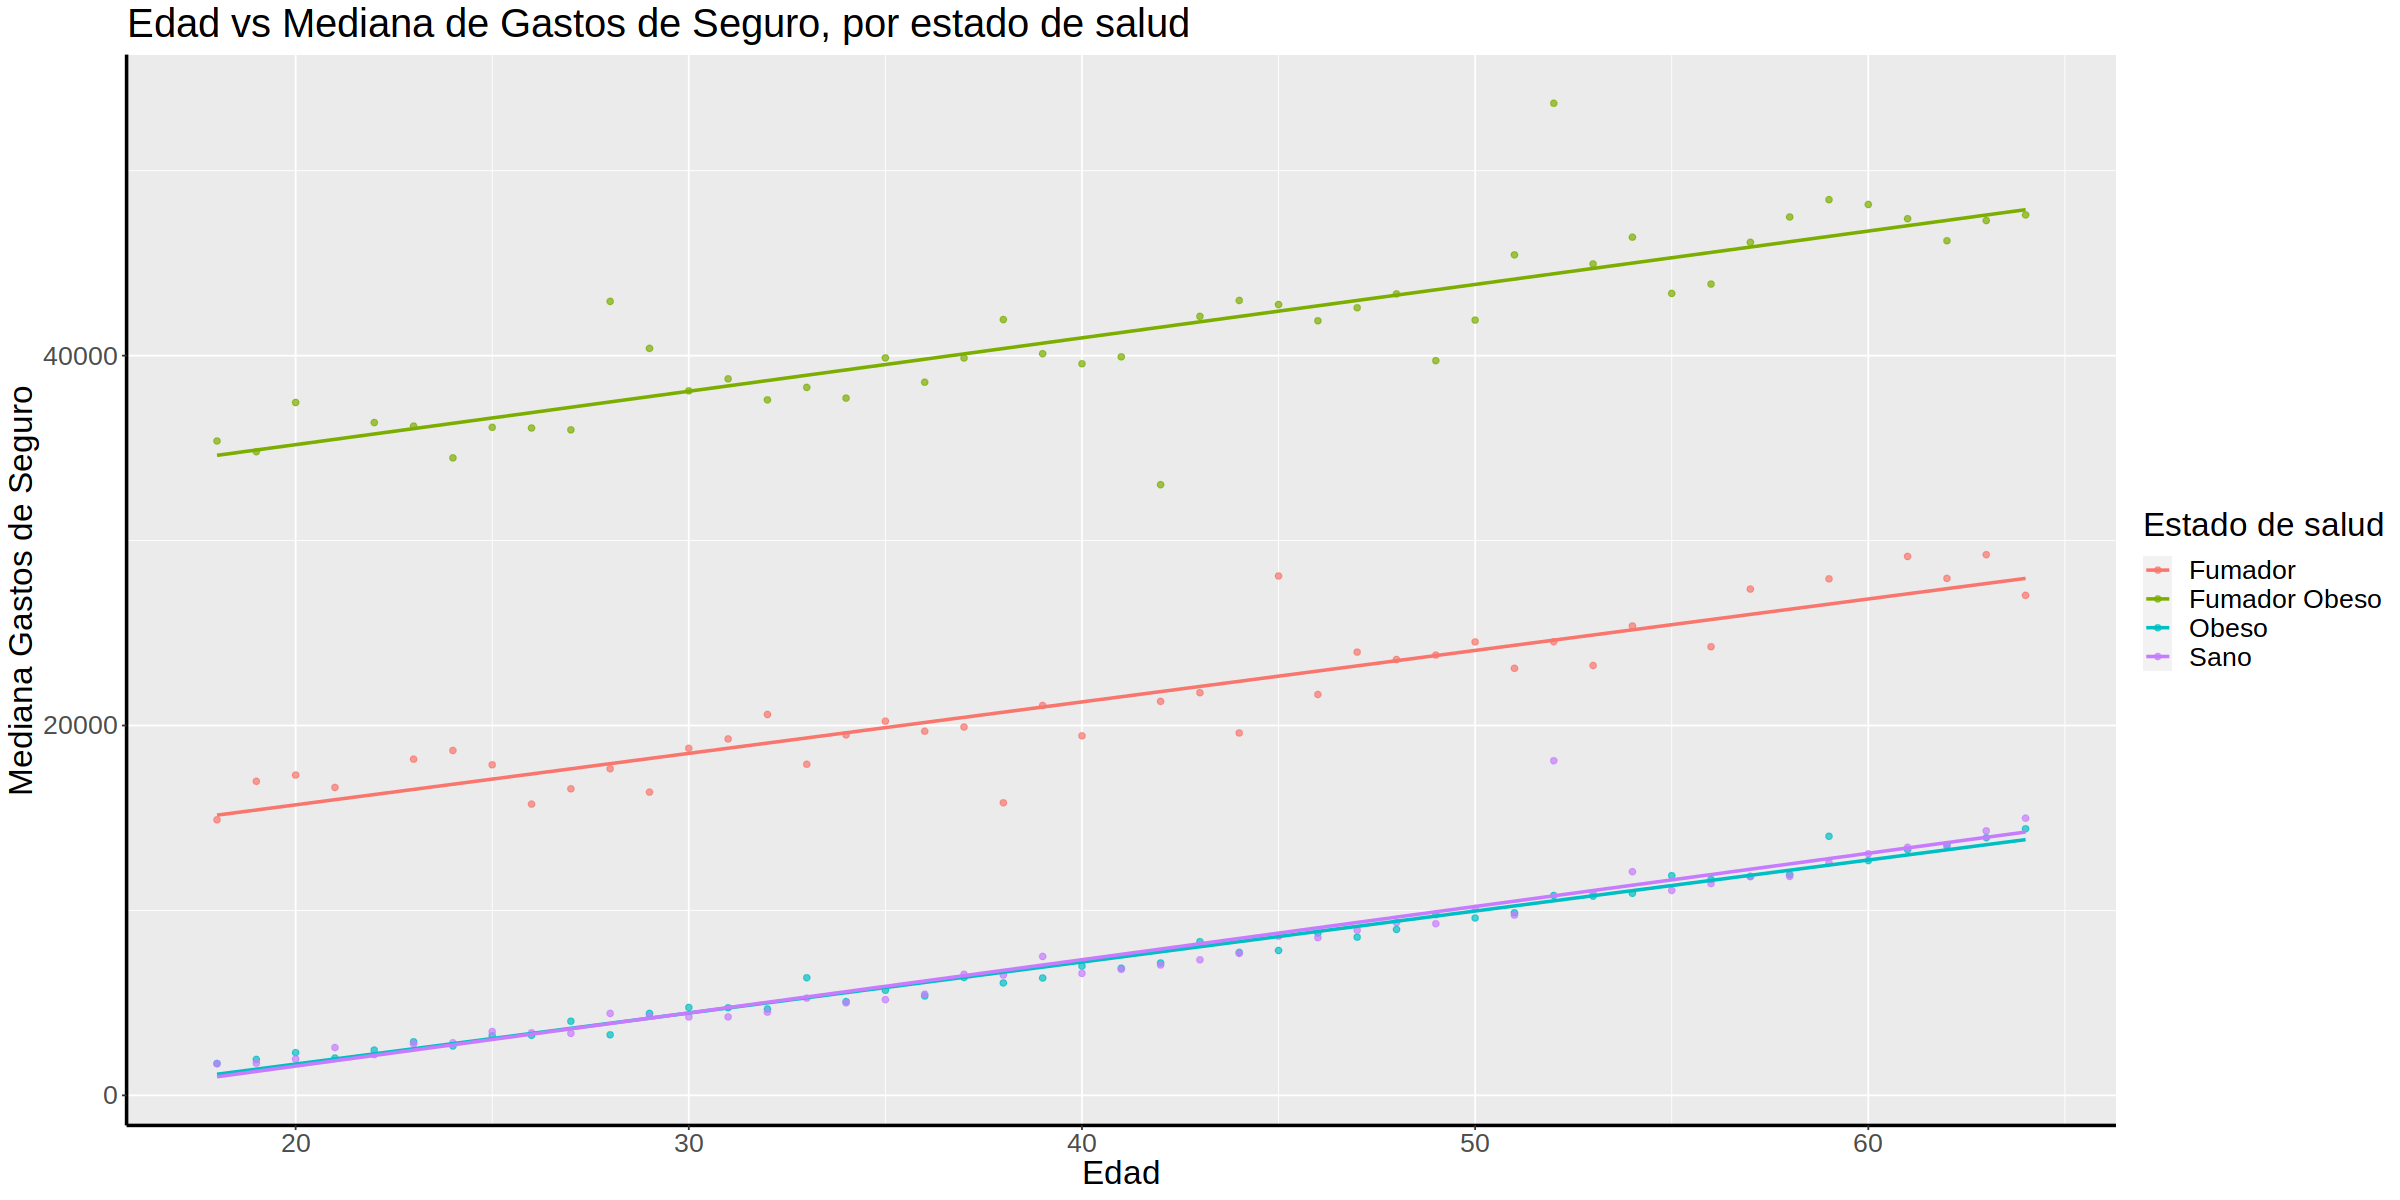

In [20]:
ggplot(metricas_df3, aes(x=age, y=mediana_ch, color = salud)) +
    geom_point(alpha=0.7) + geom_smooth(method='lm', se=FALSE, formula= y ~ x) +
    #stat_regline_equation(aes(label = ..eq.label..)) +
    labs(
        x = 'Edad',
        y = 'Mediana Gastos de Seguro',
        title = 'Edad vs Mediana de Gastos de Seguro, por estado de salud',
        # tag = 'Se incluyen las ecuaciones de las líneas de tendencia',
        color = 'Estado de salud'
    ) +
    scale_color_discrete(labels = c('Fumador','Fumador Obeso','Obeso','Sano')) +
    theme(axis.line = element_line(colour = "black", size = 1), text = element_text(size = 20))

#### made it by: <a id="5"></a> Pablo Peitsch <a href="https://github.com/PPeitsch">@PPeitsch</a>

In [30]:
fig_folder <- "fig"

In [81]:
p1 <- ggplot(df_seguros, aes(x=age, y=charges)) +
    geom_point(alpha=0.7, size=3, colour="red") +
    labs(
        x = 'Edad (años)',
        y = 'Cargos de Seguro (usd)',
        title = 'Gastos de Seguro vs Edad',
    ) +
    theme(axis.line = element_line(colour = "black", size = 1), text = element_text(size = 20))
fig1_name <- "fig1.jpeg"

In [82]:
options(repr.plot.width=24, repr.plot.height=6)
jpeg(file=file.path(fig_folder, fig1_name), width=1200, height=600)
p1
dev.off()

png 
  2

In [83]:
p2 <- ggplot(df_seguros, aes(x=age, y=charges, color=salud)) +
    geom_point(alpha=0.7) + geom_smooth(method='lm', se=FALSE, formula= y ~ x) +
    #stat_regline_equation(aes(label = ..eq.label..)) +
    labs(
        x = 'Edad (años)',
        y = 'Cargos de Seguro (usd)',
        title = 'Gastos de Seguro vs Edad',
        # tag = 'Se incluyen las ecuaciones de las líneas de tendencia',
        color = 'Estado de salud'
    ) +
    scale_color_discrete(labels = c('Tabaquismo','Tabaquismo - Obesidad','Obesidad','Presume Sano')) +
    theme(axis.line = element_line(colour = "black", size = 1), text = element_text(size = 20))
fig2_name <- "fig2.jpeg"

In [84]:
options(repr.plot.width=24, repr.plot.height=6)
jpeg(file=file.path(fig_folder, fig2_name), width=1200, height=600)
p2
dev.off()

png 
  2